In [1]:
from nltk.stem import WordNetLemmatizer


In [2]:
import spacy


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
## Importar las librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mode
import nltk
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException
from googletrans import Translator, LANGUAGES
import string
from num2words import num2words
import re
from nltk.corpus import cess_esp
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import stanza 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import  CountVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor



## Descarga la información relevante de la libreria nltk
nltk.download('punkt') # Tokenizador de palabras
nltk.download('cess_esp') # Corpus en español
nltk.download('stopwords') # Palabras vacias
nltk.download('wordnet') # Sinonimos
stanza.download('es')


C:\Users\carlo\AppData\Local\Temp\ipykernel_12996\2992563587.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cess_esp to
[nltk_data]     C:

In [5]:
## Importar el dataset
filepath = 'tipo1_entrenamiento_estudiantes.csv'
dataset = pd.read_csv(filepath)

In [6]:
# Define las contracciones del español
contracciones = {
    "q": "que",
    "d": "de",
    "t": "te",
    "m": "me",
    "na": "nada",
    "toy": "estoy",
    "toy": "estoy",
    "sta": "esta",
    "tamos": "estamos",
    'verm': 'ver',
    "al": "a el",
    "del": "de el",
    "bn": "bien",}

In [7]:
# Da un listado de las palabras que no tienen mucha utilidad en español
spanish_stopwords = set(stopwords.words('spanish'))



# Entendimiento de los datos

Iniciaremos por entender los datos que compondrán nuestro dataframe.

In [9]:
#Muestra las primeras filas del dataset
dataset.head()

,Review,Class
0,Nos alojamos en una casa alquilada en la ciuda...,4
1,"La comida está bien, pero nada especial. Yo te...",3
2,"En mi opinión, no es una como muchos usuarios ...",3
3,esta curiosa forma que asemeja una silla de mo...,4
4,Lo mejor era la limonada. Me gusto la comida d...,2


In [10]:
# Revisa el idioma del dataset
analisis= dataset.copy()

# #Se define una función que detecta el idioma de un texto
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "Unknown"

# Apply the language detection function to the first few rows as a test
analisis['lenguaje']=dataset['Review'].apply(detect_language)
language_counts = analisis['lenguaje'].value_counts()
language_counts

lenguaje
es    7868
en       6
pt       1
Name: count, dtype: int64

In [11]:
# Muestra las filas en inglés

# Filter the dataset for reviews estimated to be in English
english_reviews = analisis[analisis['lenguaje'] == 'en']

# Show the filtered rows
english_reviews[['Review', 'lenguaje']]

,Review,lenguaje
552,"Es tremendo, estuve en este lugar y la comida ...",en
743,A must when you're in Bogota and it's just in ...,en
1497,First time in Colombia and the Hotel and servi...,en
2739,El hotel es muy caro para lo que verdaderament...,en
3368,My expectations about this hotel were high due...,en
4835,This mercado is just like every mercado that I...,en


In [12]:
# Muestra las filas en portugués

# Filter the dataset for reviews estimated to be in English
portuguese_reviews = analisis[analisis['lenguaje'] == 'pt']

# Show the filtered rows
portuguese_reviews[['Review', 'lenguaje']]

,Review,lenguaje
1932,Parada obrigatório em Havana para tomar o icôn...,pt


In [13]:
# Revisa la información del dataset
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


Nótese que no existe ningún dato faltante, también que todos los elementos de la clase son del tipo entero, por lo que no hay errores en la variable numérica. 

In [14]:
# Distribución de la columna Class
dataset['Class'].value_counts()

Class
5    2350
4    1971
3    1568
2    1173
1     813
Name: count, dtype: int64

Nótese que la distribución de la información respecto a la columna clase está desbalanceada, entonces hay más datos clasificados en las clases más altas

In [15]:
# Revisa la información de las palabras en lo que respecta a la variable categórica.


analisis['NumPalabras']= [len(word) for word in dataset['Review']]
analisis['Moda'] = analisis['Review'].apply(lambda review: mode([len(word) for word in review.split()]) if review else None)
analisis['Max'] = [max([len(word) for word in review.split(' ')]) for review in analisis['Review']]
analisis['Min'] = [min([len(word) for word in review.split(' ')]) for review in analisis['Review']]

analisis

,Review,Class,lenguaje,NumPalabras,Moda,Max,Min
0,Nos alojamos en una casa alquilada en la ciuda...,4,es,416,2,13,1
1,"La comida está bien, pero nada especial. Yo te...",3,es,263,2,14,1
2,"En mi opinión, no es una como muchos usuarios ...",3,es,612,3,16,1
3,esta curiosa forma que asemeja una silla de mo...,4,es,180,2,9,2
4,Lo mejor era la limonada. Me gusto la comida d...,2,es,88,2,9,1
...,...,...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,es,624,2,13,0
7871,Es difícil revisar el castillo porque apenas p...,3,es,609,2,15,1
7872,Si vas a Mérida no puedes perderte de este lug...,5,es,168,3,9,1
7873,"Este imperdible sitio, que lleva el nombre del...",5,es,424,2,18,0


# Preparación de los datos

En la preparación de los datos se van a realizar los siguientes pasos:
* Traducción de datos 
* Limpieza de datos
* Tokenización
* Normalización
* Lematización

In [16]:
# Crea un dataset diferente para hacer la preparación de los datos
prepData= analisis.copy()

## Traducción de los datos ajenos al idioma

In [17]:
#Se traducen los idiomas ajenos al lenguaje español
translator = Translator()
def translate_to_spanish(text):
    # Detecta el idioma del texto
    detected = translator.detect(text)
    
    # Verifica si el texto ya está en español
    if detected.lang == 'es':
        return text
    
    # Si el texto no está en español, lo traduce al español
    translated = translator.translate(text, src=detected.lang, dest='es')
    return translated.text
if 'lenguaje' in prepData.columns:
    prepData.loc[prepData['lenguaje'] == 'pt', 'Review'] = prepData.loc[prepData['lenguaje'] == 'pt', 'Review'].apply(lambda x: translate_to_spanish(x))
    prepData.loc[prepData['lenguaje'] == 'en', 'Review'] = prepData.loc[prepData['lenguaje'] == 'en', 'Review'].apply(lambda x: translate_to_spanish(x))
    portuguese_reviews = prepData[prepData['lenguaje'] == 'pt']
    portuguese_reviews[['Review', 'lenguaje']]
    #Verifica que se haya traducido el portugués
    print(portuguese_reviews[['Review', 'lenguaje']])
    english_reviews = prepData[prepData['lenguaje'] == 'en']
    #Verifica que se haya traducido el inglés
    print(english_reviews[['Review', 'lenguaje']])
    prepData.drop('lenguaje', axis=1, inplace=True)

                                                 Review lenguaje
1932  Parada obligatoria en La Habana para tomar la ...       pt
                                                 Review lenguaje
552   Es tremendo, estuve en este lugar y la comida ...       en
743   Una visita obligada cuando estás en Bogotá y e...       en
1497  La primera vez en Colombia y el hotel y el ser...       en
2739  El hotel es muy caro para lo que verdaderament...       en
3368  Mis expectativas sobre este hotel fueron altas...       en
4835  Este mercado es como todos los mercados que he...       en


## Limpieza de datos

Para la limpieza de datos se va a garantizar que :
* Se deja todo en minuscula
* Remover carácteres no deseados
* Remover puntuación
* Manejar valores numéricos
* Remover palabras que no tienen un gran sentimiento (StopWords)

In [18]:
## Se deja todo en minuscula
def lower_case_words(tokenized_words):
    """Convert all words in a list to lowercase."""
    # Use a list comprehension to convert each word in the list to lowercase
    lowercased_words = [word.lower() for word in tokenized_words]
    
    return lowercased_words

In [19]:
# Elimina todos los elementos que no son necesarios y no se buscan utilizar

def remove_unwanted_characters_from_tokens(tokenized_words):
    """Remove unwanted non-ASCII characters from a list of tokenized words, retaining Spanish characters."""
    # Include the Spanish alphabet, both lowercase and uppercase, digits, and common punctuation
    allowed_characters = set("abcdefghijklmnopqrstuvwxyzáéíóúüñABCDEFGHIJKLMNOPQRSTUVWXYZÁÉÍÓÚÜÑ " + string.digits + string.punctuation)
    
    # Initialize an empty list to hold the cleaned words
    new_words = []
    
    # Iterate over each word in the list of tokenized words
    for word in tokenized_words:
        # Filter each word to include only allowed characters
        cleaned_word = ''.join(char for char in word if char in allowed_characters)
        # Append the cleaned word to the new list
        if cleaned_word == word:
            # If they are the same, it means the word contains only allowed characters, so append it to the list
            new_words.append(cleaned_word)
    
    return new_words

In [20]:
# Remueve la punctuación dentro de cada palabra
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words, with explicit support for Unicode characters."""
    new_words = []
    for word in words:
        if word is not None:
            # Use \w for word characters, \s for whitespace, and ensure Unicode support
            new_word = re.sub(r'[^\w\s]', '', word, flags=re.UNICODE)
            if new_word != '':
                new_words.append(new_word)
    return new_words

In [21]:
# Convierte los números a palabras
def convert_numbers_to_words(words):
    """Convert all numbers in a text to their word representation in the specified language."""
    
    # Convert each word
    new_words = []
    for word in words:
        if word.isdigit():
            word= float(word)
            # Convert the numerical word to its word representation
            word_in_text = num2words(word, lang='es')
            new_words.append(word_in_text)
        else:
            new_words.append(word)
    return new_words

In [22]:
# Remueve las stopwords o palabras sin mucha prioridad en el analisis
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    # Filter out any words that are in the list of stop words
    filtered_words = [word for word in words if word not in spanish_stopwords]
    return filtered_words

In [23]:
def preprocessing(words):
    """Preprocess a list of tokenized words"""
    # Remove unwanted characters
    words = remove_unwanted_characters_from_tokens(words)
    # Convert to lowercase
    words = lower_case_words(words)
    # Convert numbers to words
    words = convert_numbers_to_words(words)
    # Remove punctuation
    words = remove_punctuation(words)
    # Remove stop words
    words = remove_stopwords(words)
    return words

## Tokenización

La tokenización divide el texto en unidades más pequeñas, como palabras o símbolos, para análisis. La usaremos para descomponer el texto en tokens individuales, facilitando análisis posteriores.

In [24]:
#Expandir las contracciones y reemplazarlas
def expandir_contracciones(texto, contracciones_dict):
    """
    Expande las contracciones encontradas en el texto basándose en un diccionario de contracciones.
    """
    # Asegurarse de que la expresión regular coincide solo con palabras completas. 
    # \b es un límite de palabra, lo que ayuda a coincidir solo palabras completas.
    contracciones_re = re.compile(r'\b(%s)\b' % '|'.join(map(re.escape, contracciones_dict.keys())))

    def reemplazo(match):
        return contracciones_dict[match.group(0)]

    texto_expandido = contracciones_re.sub(reemplazo, texto)
    
    return texto_expandido

prepData['Review'] = prepData['Review'].apply(expandir_contracciones, contracciones_dict=contracciones)
prepData

,Review,Class,NumPalabras,Moda,Max,Min
0,Nos alojamos en una casa alquilada en la ciuda...,4,416,2,13,1
1,"La comida está bien, pero nada especial. Yo te...",3,263,2,14,1
2,"En mi opinión, no es una como muchos usuarios ...",3,612,3,16,1
3,esta curiosa forma que asemeja una silla de mo...,4,180,2,9,2
4,Lo mejor era la limonada. Me gusto la comida d...,2,88,2,9,1
...,...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,624,2,13,0
7871,Es difícil revisar el castillo porque apenas p...,3,609,2,15,1
7872,Si vas a Mérida no puedes perderte de este lug...,5,168,3,9,1
7873,"Este imperdible sitio, que lleva el nombre de ...",5,424,2,18,0


In [25]:
#Tokenizar
def nltk_spanish_tokenizer(text):
    return word_tokenize(text, language='spanish')
prepData['words'] = prepData['Review'].apply(lambda x: word_tokenize(x, language='spanish'))
prepData.head()


,Review,Class,NumPalabras,Moda,Max,Min,words
0,Nos alojamos en una casa alquilada en la ciuda...,4,416,2,13,1,"[Nos, alojamos, en, una, casa, alquilada, en, ..."
1,"La comida está bien, pero nada especial. Yo te...",3,263,2,14,1,"[La, comida, está, bien, ,, pero, nada, especi..."
2,"En mi opinión, no es una como muchos usuarios ...",3,612,3,16,1,"[En, mi, opinión, ,, no, es, una, como, muchos..."
3,esta curiosa forma que asemeja una silla de mo...,4,180,2,9,2,"[esta, curiosa, forma, que, asemeja, una, sill..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,88,2,9,1,"[Lo, mejor, era, la, limonada, ., Me, gusto, l..."


In [26]:
#Elimina los valores nulos del conjunto de palabras
prepData['words'].dropna()

0       [Nos, alojamos, en, una, casa, alquilada, en, ...
1       [La, comida, está, bien, ,, pero, nada, especi...
2       [En, mi, opinión, ,, no, es, una, como, muchos...
3       [esta, curiosa, forma, que, asemeja, una, sill...
4       [Lo, mejor, era, la, limonada, ., Me, gusto, l...
                              ...                        
7870    [El, motivo, de, mi, estancia, fue, porque, vi...
7871    [Es, difícil, revisar, el, castillo, porque, a...
7872    [Si, vas, a, Mérida, no, puedes, perderte, de,...
7873    [Este, imperdible, sitio, ,, que, lleva, el, n...
7874    [Festejando, Dia, de, el, Amor, y, Amistad, Te...
Name: words, Length: 7875, dtype: object

In [27]:
prepData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       7875 non-null   object
 1   Class        7875 non-null   int64 
 2   NumPalabras  7875 non-null   int64 
 3   Moda         7875 non-null   int64 
 4   Max          7875 non-null   int64 
 5   Min          7875 non-null   int64 
 6   words        7875 non-null   object
dtypes: int64(5), object(2)
memory usage: 430.8+ KB


In [28]:
#Aplica el procesamiento básico
prepData['words1']=prepData['words'].apply(preprocessing)
prepData.head()

,Review,Class,NumPalabras,Moda,Max,Min,words,words1
0,Nos alojamos en una casa alquilada en la ciuda...,4,416,2,13,1,"[Nos, alojamos, en, una, casa, alquilada, en, ...","[alojamos, casa, alquilada, ciudad, amurallada..."
1,"La comida está bien, pero nada especial. Yo te...",3,263,2,14,1,"[La, comida, está, bien, ,, pero, nada, especi...","[comida, bien, especial, mejor, comida, mexcan..."
2,"En mi opinión, no es una como muchos usuarios ...",3,612,3,16,1,"[En, mi, opinión, ,, no, es, una, como, muchos...","[opinión, usuarios, reclaman, gran, paladar, p..."
3,esta curiosa forma que asemeja una silla de mo...,4,180,2,9,2,"[esta, curiosa, forma, que, asemeja, una, sill...","[curiosa, forma, asemeja, silla, montar, ahi, ..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,88,2,9,1,"[Lo, mejor, era, la, limonada, ., Me, gusto, l...","[mejor, limonada, gusto, comida, mundo, sosa, ..."


## Normalización

El proceso de transformar el texto a una forma estándar para facilitar su análisis. La utilizaremos para estandarizar el texto, lo que simplificará el procesamiento posterior del texto en los modelos.

In [29]:
#Stemmer

stemmer = SnowballStemmer('spanish')
def stem_words(words):
    """Stem words in list of tokenized words"""
    # Stem each word in the list of words
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

#This is just for trying the stemmer
def stemExample(text):
   return [stemmer.stem(word) for word in text.split()]

In [30]:
## Apply Stemmer to the words
prepData['words2'] = prepData['words1'].apply(stem_words)
prepData.head()

,Review,Class,NumPalabras,Moda,Max,Min,words,words1,words2
0,Nos alojamos en una casa alquilada en la ciuda...,4,416,2,13,1,"[Nos, alojamos, en, una, casa, alquilada, en, ...","[alojamos, casa, alquilada, ciudad, amurallada...","[aloj, cas, alquil, ciud, amurall, parec, tan,..."
1,"La comida está bien, pero nada especial. Yo te...",3,263,2,14,1,"[La, comida, está, bien, ,, pero, nada, especi...","[comida, bien, especial, mejor, comida, mexcan...","[com, bien, especial, mejor, com, mexc, unid, ..."
2,"En mi opinión, no es una como muchos usuarios ...",3,612,3,16,1,"[En, mi, opinión, ,, no, es, una, como, muchos...","[opinión, usuarios, reclaman, gran, paladar, p...","[opinion, usuari, reclam, gran, palad, parec, ..."
3,esta curiosa forma que asemeja una silla de mo...,4,180,2,9,2,"[esta, curiosa, forma, que, asemeja, una, sill...","[curiosa, forma, asemeja, silla, montar, ahi, ...","[curios, form, asemej, sill, mont, ahi, nombr,..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,88,2,9,1,"[Lo, mejor, era, la, limonada, ., Me, gusto, l...","[mejor, limonada, gusto, comida, mundo, sosa, ...","[mejor, limon, gust, com, mund, sos, fri]"


## Lematizacion

Es un proceso lingüístico que reduce las palabras a su forma base o raíz, conocida como lema. Se utiliza para normalizar palabras y reducir la variabilidad léxica, lo que facilita el análisis de texto al agrupar palabras similares

In [31]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('es_core_news_sm')


In [32]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

In [33]:
def lemmatize_and_remove_stopwords(texto):
    doc = nlp(texto)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]  # Remover stopwords
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [34]:
prepData['lemmatized_review'] = prepData['Review'].apply(lemmatize_and_remove_stopwords)
prepData.head()

,Review,Class,NumPalabras,Moda,Max,Min,words,words1,words2,lemmatized_review
0,Nos alojamos en una casa alquilada en la ciuda...,4,416,2,13,1,"[Nos, alojamos, en, una, casa, alquilada, en, ...","[alojamos, casa, alquilada, ciudad, amurallada...","[aloj, cas, alquil, ciud, amurall, parec, tan,...",alogir casa alquilado ciudad amurallado . pare...
1,"La comida está bien, pero nada especial. Yo te...",3,263,2,14,1,"[La, comida, está, bien, ,, pero, nada, especi...","[comida, bien, especial, mejor, comida, mexcan...","[com, bien, especial, mejor, com, mexc, unid, ...","comida , especial . comida Mexcan Unidos . mar..."
2,"En mi opinión, no es una como muchos usuarios ...",3,612,3,16,1,"[En, mi, opinión, ,, no, es, una, como, muchos...","[opinión, usuarios, reclaman, gran, paladar, p...","[opinion, usuari, reclam, gran, palad, parec, ...","opinión , usuario reclamar . paladar parada gr..."
3,esta curiosa forma que asemeja una silla de mo...,4,180,2,9,2,"[esta, curiosa, forma, que, asemeja, una, sill...","[curiosa, forma, asemeja, silla, montar, ahi, ...","[curios, form, asemej, sill, mont, ahi, nombr,...",curioso forma asemejar silla montar nombre ico...
4,Lo mejor era la limonada. Me gusto la comida d...,2,88,2,9,1,"[Lo, mejor, era, la, limonada, ., Me, gusto, l...","[mejor, limonada, gusto, comida, mundo, sosa, ...","[mejor, limon, gust, com, mund, sos, fri]",limonado . gustar comida mundo sós frío .


## (NEW) Automatización de la Preparación de Datos 

Implementacion de la carga de datos y el conjunto de tecnicas de limpieza de datos, todo dentro de un solo metodo.
 
1. Carga de datos
2. Pre-procesamiento
3. Tokenizacion
4. Normalizacion
5. Lematizacion

In [87]:
from wordcloud import WordCloud


In [54]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def cargar_y_preparar_datos(filepath):
    # Carga de datos
    df = pd.read_csv(filepath)
    
    # Preprocesamiento de texto
    def preprocessing(text):
        words = nltk_spanish_tokenizer(text)
        words = [re.sub(r'[^a-zñáéíóú]', '', word.lower()) for word in words if word.isalpha() or word.isdigit()]
        words = [num2words(word, lang='es') if word.isdigit() else word for word in words]
        words = [word for word in words if word not in stopwords.words('spanish')]
        words = lemmatize_and_remove_stopwords(words)
        return ' '.join(words)
    
    df['texto_procesado'] = df['Review'].apply(preprocessing)
    return df

def nltk_spanish_tokenizer(text):
    return word_tokenize(text, language='spanish')

def lemmatize_and_remove_stopwords(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('spanish')]
    return lemmatized

df_preparado = cargar_y_preparar_datos('tipo1_entrenamiento_estudiantes.csv')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
df_preparado.head()

,Review,Class,texto_procesado
0,Nos alojamos en una casa alquilada en la ciuda...,4,alojamos casa alquilada ciudad amurallada pare...
1,"La comida está bien, pero nada especial. Yo te...",3,comida bien especial mejor comida mexcan unido...
2,"En mi opinión, no es una como muchos usuarios ...",3,opinión usuarios reclaman gran paladar parece ...
3,esta curiosa forma que asemeja una silla de mo...,4,curiosa forma asemeja silla montar ahi nombre ...
4,Lo mejor era la limonada. Me gusto la comida d...,2,mejor limonada gusto comida mundo sosa frío


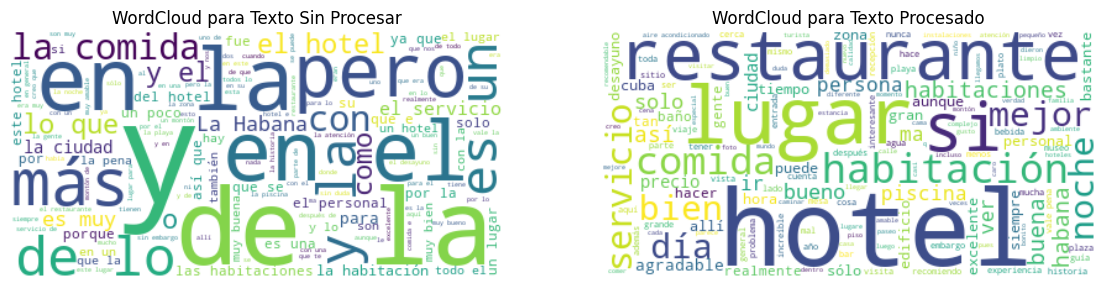

In [88]:
texto_sin_procesar = " ".join(review for review in df_preparado.Review)
wordcloud_sin_procesar = WordCloud(background_color="white").generate(texto_sin_procesar)

texto_procesado = " ".join(review for review in df_preparado.texto_procesado)
wordcloud_procesado = WordCloud(background_color="white").generate(texto_procesado)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sin_procesar, interpolation='bilinear')
plt.title('WordCloud para Texto Sin Procesar')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_procesado, interpolation='bilinear')
plt.title('WordCloud para Texto Procesado')
plt.axis('off')

plt.show()

# Creación e implementación de modelos

Una vez que tenemos nuestros datos procesados, procederemos a aplicar diferentes modelos sobre nuestro dataframe procesado. La regresión logística, el bosque aleatorio y la red neuronal son los modelos que elegimos implementar. La regresión logística es adecuada para problemas de clasificación binaria y multinomial, como este. El bosque aleatorio es robusto, maneja bien características irrelevantes y no linealidades. Las redes neuronales, con su capacidad para aprender representaciones complejas, son útiles para capturar relaciones no lineales en los datos. Procedemos a calcular la precisión (accuracy) para cada alternativa para concluir cuál soluciona mejor el problema

In [35]:
## Unificación de las palabras
molData=prepData.copy()
molData['words'] = molData['words2'].apply(lambda x: ' '.join(map(str, x)))
molData

,Review,Class,NumPalabras,Moda,Max,Min,words,words1,words2,lemmatized_review
0,Nos alojamos en una casa alquilada en la ciuda...,4,416,2,13,1,aloj cas alquil ciud amurall parec tan segur c...,"[alojamos, casa, alquilada, ciudad, amurallada...","[aloj, cas, alquil, ciud, amurall, parec, tan,...",alogir casa alquilado ciudad amurallado . pare...
1,"La comida está bien, pero nada especial. Yo te...",3,263,2,14,1,com bien especial mejor com mexc unid margarit...,"[comida, bien, especial, mejor, comida, mexcan...","[com, bien, especial, mejor, com, mexc, unid, ...","comida , especial . comida Mexcan Unidos . mar..."
2,"En mi opinión, no es una como muchos usuarios ...",3,612,3,16,1,opinion usuari reclam gran palad parec ser par...,"[opinión, usuarios, reclaman, gran, paladar, p...","[opinion, usuari, reclam, gran, palad, parec, ...","opinión , usuario reclamar . paladar parada gr..."
3,esta curiosa forma que asemeja una silla de mo...,4,180,2,9,2,curios form asemej sill mont ahi nombr icon ci...,"[curiosa, forma, asemeja, silla, montar, ahi, ...","[curios, form, asemej, sill, mont, ahi, nombr,...",curioso forma asemejar silla montar nombre ico...
4,Lo mejor era la limonada. Me gusto la comida d...,2,88,2,9,1,mejor limon gust com mund sos fri,"[mejor, limonada, gusto, comida, mundo, sosa, ...","[mejor, limon, gust, com, mund, sos, fri]",limonado . gustar comida mundo sós frío .
...,...,...,...,...,...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,624,2,13,0,motiv estanci vin congres medic hosped lug ins...,"[motivo, estancia, vine, congreso, medico, hos...","[motiv, estanci, vin, congres, medic, hosped, ...","motivo estancia venir congreso medico , hosped..."
7871,Es difícil revisar el castillo porque apenas p...,3,609,2,15,1,dificil revis castill apen pod camin sofoc cal...,"[difícil, revisar, castillo, apenas, podíamos,...","[dificil, revis, castill, apen, pod, camin, so...",difícil revisar castillo poder caminar sofocan...
7872,Si vas a Mérida no puedes perderte de este lug...,5,168,3,9,1,si vas mer pued perdert lug nuev sucursal ampl...,"[si, vas, mérida, puedes, perderte, lugar, nue...","[si, vas, mer, pued, perdert, lug, nuev, sucur...",ir Mérida poder perderte lugar sucursal amplio...
7873,"Este imperdible sitio, que lleva el nombre de ...",5,424,2,18,0,imperd siti llev nombr conquist joy urbanasu a...,"[imperdible, sitio, lleva, nombre, conquistado...","[imperd, siti, llev, nombr, conquist, joy, urb...","imperdible sitio , nombre conquistador , joya ..."


In [36]:
## Crea el test y el train set

X_train, X_test, y_train, y_test = train_test_split(molData['words'], molData['Class'], test_size=0.2, random_state=42)

## Regresión logistica

Es un algoritmo de aprendizaje supervisado utilizado principalmente para problemas de clasificación binaria. Aunque su nombre incluye "regresión", en realidad es un modelo de clasificación.

In [37]:
vectorizer = CountVectorizer()
X_train_transformed  = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)
print(X_train_transformed .shape)


(6300, 12922)


In [38]:
tfid= TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
X_train_transformed=tfid.fit_transform(X_train_transformed)
X_test_transformed=tfid.transform(X_test_transformed)

In [39]:
# Initialize and train logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_transformed, y_train)

# Predictions on test data
y_pred = logistic_model.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.49777777777777776


In [40]:
svm = LinearSVC(random_state=42)
svm.fit(X_train_transformed, y_train)
y_pred_svm_sample = svm.predict(X_test_transformed)
accuracy_svm = accuracy_score(y_test, y_pred_svm_sample)
print("Accuracy:", accuracy_svm)

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.47619047619047616


## Random Forest

Se basa en la construcción de múltiples árboles de decisión durante el entrenamiento y combina sus predicciones para obtener una predicción más precisa y estable.

In [41]:
# Initialize and train Random Forest on the reduced dataset
random_forest_sample = RandomForestClassifier(random_state=42)
random_forest_sample.fit(X_train_transformed, y_train)

# Predict on the test set and calculate accuracy
y_pred_rf_sample = random_forest_sample.predict(X_test_transformed)
accuracy_rf_sample = accuracy_score(y_test, y_pred_rf_sample)

print("Accuracy:",accuracy_rf_sample)

Accuracy: 0.4711111111111111


## (NEW) Construcción y Entrenamiento del Modelo

In [60]:
from sklearn.metrics import classification_report, accuracy_score


In [61]:

# Creación del pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(df_preparado['texto_procesado'], df_preparado['Class'], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:", classification_report(y_test, predictions))


Accuracy: 0.4488888888888889
Classification Report:               precision    recall  f1-score   support

           1       0.57      0.18      0.28       163
           2       0.39      0.35      0.37       226
           3       0.40      0.26      0.32       319
           4       0.37      0.37      0.37       389
           5       0.51      0.77      0.62       478

    accuracy                           0.45      1575
   macro avg       0.45      0.39      0.39      1575
weighted avg       0.44      0.45      0.43      1575



Guardar Pipeline

In [62]:
import joblib

In [63]:
joblib.dump(pipeline, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

## Neural Network

Son modelos de aprendizaje profundo inspirados en el funcionamiento del cerebro humano. Consisten en capas de nodos (neuronas) interconectados que procesan información y aprenden representaciones de los datos.

In [42]:
# Initialize the neural network model
# Let's use a simple architecture with two hidden layers of 100 neurons each
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=300, activation='relu', solver='adam', random_state=42)

# Train the neural network on the reduced dataset
mlp.fit(X_train_transformed, y_train)

# Predict on the test set and calculate accuracy
y_pred_mlp = mlp.predict(X_test_transformed)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

accuracy_mlp

0.433015873015873

### F1-Score


El F1 score mide la precisión y cobertura de un modelo, crucial para evaluar su desempeño en clasificaciones donde cada clase importa, como en análisis de texto con varias calificaciones.

In [43]:
from sklearn.metrics import f1_score

# Para el modelo de regresión logística
f1_score_logistic = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (Logistic Regression):", f1_score_logistic)

# Para el modelo SVM
f1_score_svm = f1_score(y_test, y_pred_svm_sample, average='weighted')
print("F1 Score (SVM):", f1_score_svm)

# Para el modelo de Random Forest
f1_score_rf = f1_score(y_test, y_pred_rf_sample, average='weighted')
print("F1 Score (Random Forest):", f1_score_rf)

# Para el modelo de red neuronal (MLPClassifier)
f1_score_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
print("F1 Score (Neural Network):", f1_score_mlp)


F1 Score (Logistic Regression): 0.4901743392033223
F1 Score (SVM): 0.4707674048936117
F1 Score (Random Forest): 0.4477354643942914
F1 Score (Neural Network): 0.43105078628630206


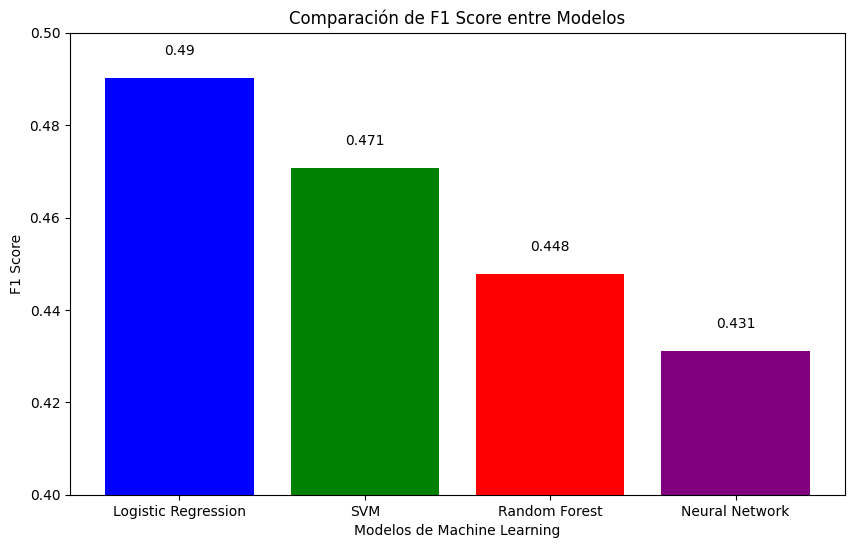

In [89]:

model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'Neural Network']
f1_scores = [0.4901743392033223, 0.4707674048936117, 0.4477354643942914, 0.43105078628630206]

plt.figure(figsize=(10, 6))
plt.bar(model_names, f1_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Modelos de Machine Learning')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score entre Modelos')
plt.ylim(0.4, 0.5)  

for i in range(len(f1_scores)):
    plt.text(i, f1_scores[i] + 0.005, round(f1_scores[i], 3), ha = 'center')

plt.show()


## Decision Tree

Son modelos de aprendizaje supervisado que pueden ser utilizados para problemas de clasificación y regresión.

In [44]:
#DecisionTree
# Initialize the Decision Tree Regressor
decision_tree_regressor = DecisionTreeRegressor(random_state=42)

# Train the regressor on the reduced dataset
decision_tree_regressor.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred_dtr = decision_tree_regressor.predict(X_test_transformed)

# For regression tasks, we typically use different metrics than accuracy, such as Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred_dtr)

### Menos es mejor
print(mae)

0.9574603174603175


### Creacion de predicciones

La regresión logística nos proporcionó la mayor precisión, por lo que decidimos utilizarla. Aunque los otros modelos nos dieron valores cercanos, optamos por recomendar el modelo de regresión logística.

In [45]:
prueba_estudiantes = pd.read_csv('particion_prueba_estudiantes.csv')


In [46]:
prueba_estudiantes['words'] = prueba_estudiantes['Review'].apply(lambda x: ' '.join(map(str, x)))


In [47]:
X_prueba_transformed = vectorizer.transform(prueba_estudiantes['words'])
X_prueba_transformed = tfid.transform(X_prueba_transformed)

In [48]:
y_pred_prueba = logistic_model.predict(X_prueba_transformed)


In [49]:
prueba_estudiantes['Prediction'] = y_pred_prueba


In [50]:
prueba_estudiantes.to_csv('prueba_estudiantes_con_predicciones.csv', index=False)
print("Predicciones guardadas en 'prueba_estudiantes_con_predicciones.csv'")

Predicciones guardadas en 'prueba_estudiantes_con_predicciones.csv'


(NEW) API 

In [86]:
%pip install fastapi uvicorn


   ---------------------------------------- 0.0/91.9 kB ? eta -:--:--
   ----------------------------------- ---- 81.9/91.9 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 91.9/91.9 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
   ---------------------------------------- 60.8/60.8 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/71.9 kB ? eta -:--:--
   ---------------------------------------- 71.9/71.9 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/85.6 kB ? eta -:--:--
   ---------------------------------------- 85.6/85.6 kB 5.0 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
